Jahnvi Shah
<br>2018130047

**Objective**: To perform time series analysis: identifying the nature of the phenomenon represented by the sequence of observations, and forecasting


1. Create time series data.

· Replication requirements: What you’ll need to reproduce the analysis

· Creating time series objects: Convert your data to a time series object for time series analysis

In [1]:
# Regular libraries for data manipulation
import pprint
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Visualization
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tools for time series analysis
from scipy import signal
import statsmodels.api as sm
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

from pylab import rcParams

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 42.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('drive/MyDrive/Datasets/Stock Prices/preprocessed_CAC40.csv')

In [4]:
data.columns


Index(['Unnamed: 0', 'Name', 'Date', 'Open', 'Closing_Price', 'Daily_High',
       'Daily_Low', 'Volume'],
      dtype='object')

In [5]:
data['Name'].unique()

array(['Accor', 'Air Liquide', 'Airbus ', 'ArcelorMittal', 'Atos', 'AXA',
       'BNP Paribas', 'Bouygues', 'Cap Gemini', 'Crédit Agricole',
       'Danone', 'Dassault Systèmes', 'Engie (ex GDF Suez',
       'EssilorLuxottica', 'Hermès (Hermes International', 'Kering',
       'LEGRAND', 'LOréal', 'LVMH Moet Hennessy Louis Vuitton',
       'Michelin (Compagnie Générale d Etablissements Michelin SCPA',
       'Orange', 'Pernod Ricard', 'Peugeot', 'Publicis', 'Renault',
       'SAFRAN', 'Saint-Gobain', 'Sanofi', 'Schneider Electric',
       'Société Générale (Societe Generale', 'Sodexo',
       'STMicroelectronics', 'TOTAL', 'Unibail-Rodamco',
       'Veolia Environnement', 'VINCI', 'Vivendi', 'Worldline SA'],
      dtype=object)

In [6]:
# Filter the dataframe on Air Liquide stocks
air_liquide = data[data['Name'] == 'Air Liquide'].copy()

In [7]:
# Converting 'Date' to datetime object
air_liquide['Date'] = pd.to_datetime(air_liquide['Date'])
air_liquide['Year'] = air_liquide['Date'].dt.year
air_liquide['Month'] = air_liquide['Date'].dt.month

In [8]:
print(f'air_liquide shape: {air_liquide.shape[0]} rows, {air_liquide.shape[1]} columns')

air_liquide shape: 2600 rows, 10 columns


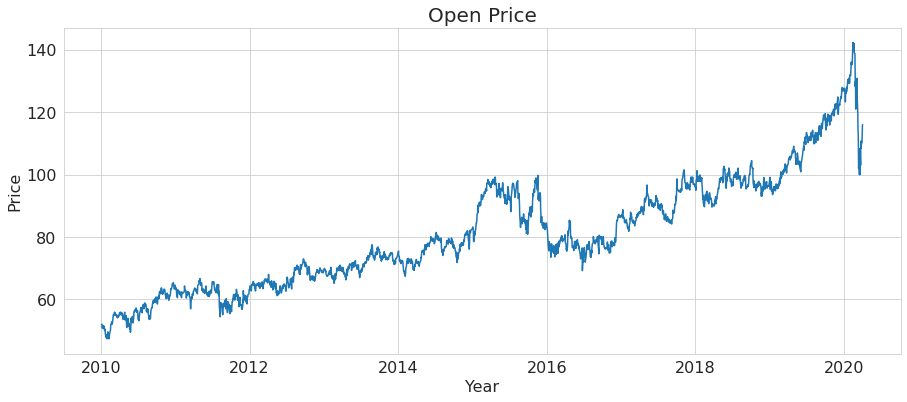

In [9]:
# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(air_liquide['Date'], air_liquide['Open'] )

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center')
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Price', fontsize = 16)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

In [10]:
#The data don't seem to show seasonality within each year. There is rather a trend than a cyclic behavior. 

Treatment of missing values

In [11]:
# check NaN 
air_liquide.isna().sum()
air_liquide = air_liquide.drop(['Unnamed: 0'], axis=1)

In [12]:
# replacing the missing value by the Open price value of the previous day (backward fill)
air_liquide['Open'] = air_liquide['Open'].fillna(method='bfill')

In [13]:
print(f"Percentage of missing values in Volume: {round(sum(pd.isnull(air_liquide['Volume']))/air_liquide.shape[0],2)}\n")
print(air_liquide[air_liquide['Volume']==0])

Percentage of missing values in Volume: 0.05

Empty DataFrame
Columns: [Name, Date, Open, Closing_Price, Daily_High, Daily_Low, Volume, Year, Month]
Index: []


In [14]:
# Imputation
imputer = SimpleImputer(strategy='constant', fill_value=0)
air_liquide_plus = imputer.fit_transform(air_liquide)

# Imputation removed column names; put them back
imputed_air_liquide = pd.DataFrame(air_liquide_plus)
imputed_air_liquide.columns = air_liquide.columns

In [15]:
# Replace , by . so Volume can be converted as float
imputed_air_liquide['Volume'] = imputed_air_liquide['Volume'].apply(lambda x : str(x))
imputed_air_liquide['Volume'] = pd.to_numeric(imputed_air_liquide['Volume'].apply(lambda x : x.replace(',','',1)))

# Convert object to numeric 
imputed_air_liquide['Open'] = pd.to_numeric(imputed_air_liquide['Open'])
imputed_air_liquide['Closing_Price'] = pd.to_numeric(imputed_air_liquide['Closing_Price'])
imputed_air_liquide['Daily_High'] = pd.to_numeric(imputed_air_liquide['Daily_High'])
imputed_air_liquide['Daily_Low'] = pd.to_numeric(imputed_air_liquide['Daily_Low'])

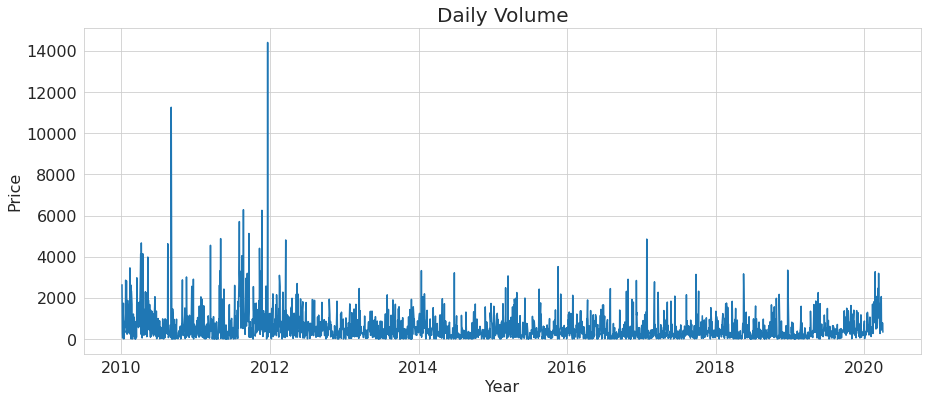

In [19]:
# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(imputed_air_liquide['Date'], imputed_air_liquide['Volume'] )

ax.set_title('Daily Volume', fontsize = 20, loc='center')
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Price', fontsize = 16)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

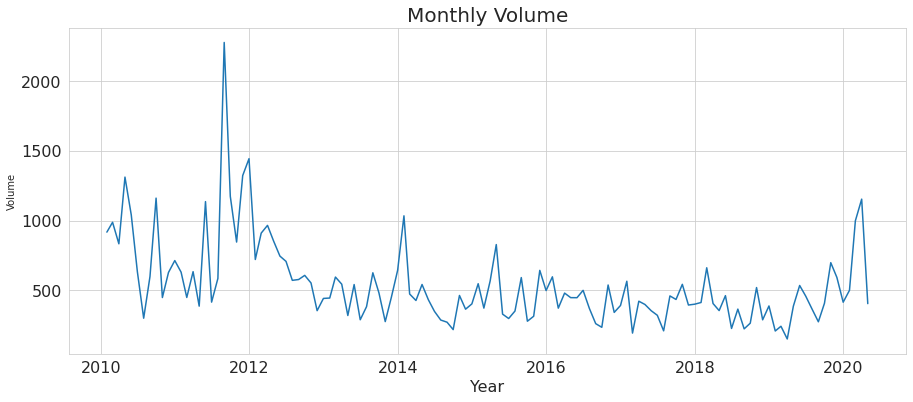

In [20]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Volume']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
y['Date'] = y.index

# Plot the Monthly Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(y['Date'], y['Volume'] )

ax.set_title('Monthly Volume', fontsize = 20, loc='center')
ax.set_xlabel('Year', fontsize = 16)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

Seasonality

In [21]:
imputed_air_liquide['Year'].unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010],
      dtype=object)

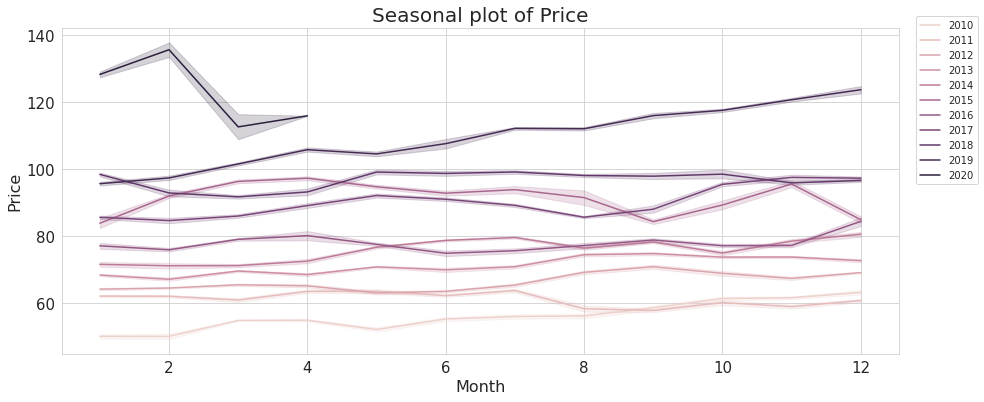

In [22]:
variable = 'Open'
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(imputed_air_liquide['Month'], imputed_air_liquide[variable], hue = imputed_air_liquide['Year'])
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center')
ax.set_xlabel('Month', fontsize = 16)
ax.set_ylabel('Price', fontsize = 16)
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))

We can see directly that 2019 was a very good year for the firm. The share price rose from 95 euros to 125 euros. This is the biggest increase over the last 10 years.

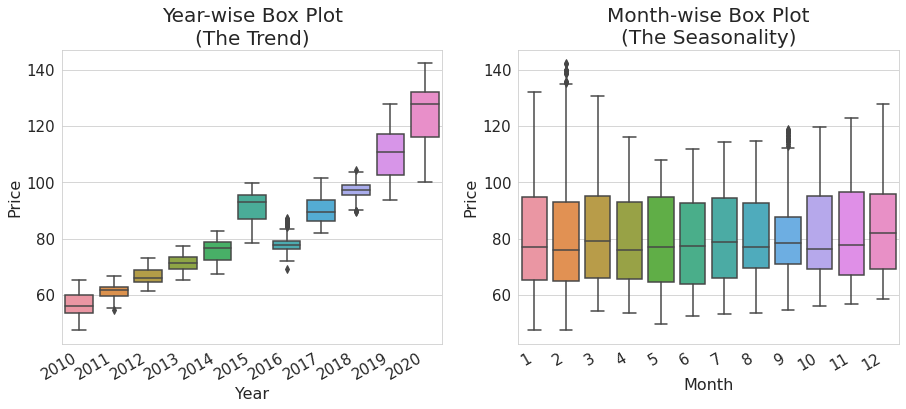

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.boxplot(imputed_air_liquide['Year'], imputed_air_liquide[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center')
ax[0].set_xlabel('Year', fontsize = 16)
ax[0].set_ylabel('Price', fontsize = 16)

sns.boxplot(imputed_air_liquide['Month'], imputed_air_liquide[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center')
ax[1].set_xlabel('Month', fontsize = 16)
ax[1].set_ylabel('Price', fontsize = 16)

fig.autofmt_xdate()



Year wise Box Plot

Few outliers, no seasonality and an uptrend for the last decade except for 2016. This small slowdown is characterized by the completion of the Airgas acquisition, in 2016, and its first contribution to the Group's performance. You can read the full 2016 report here

Month wise Box Plot

The variance between each class is really small, it shows clearly that there is no effect of seasonality.

Text(0, 0.5, 'Closing_Price')

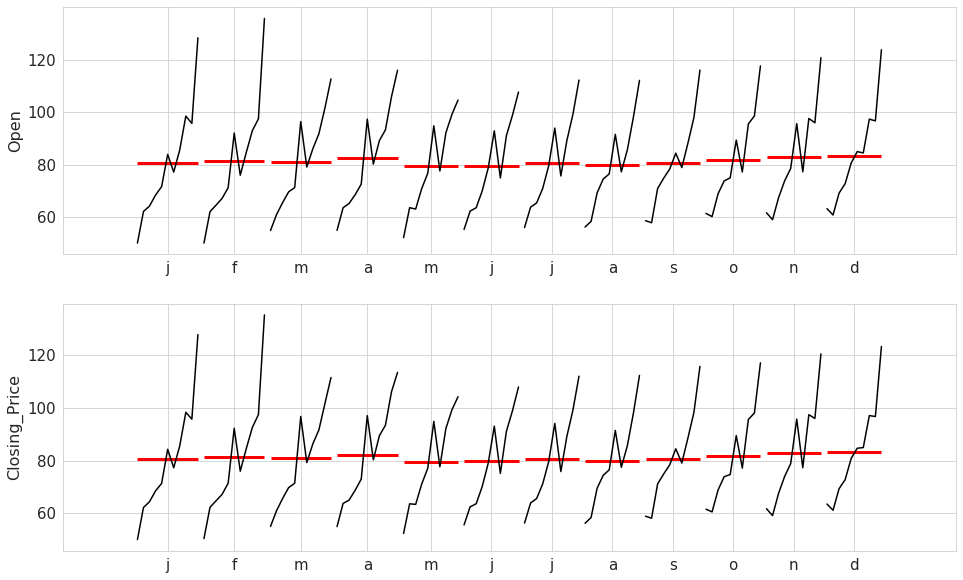

In [24]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open','Closing_Price']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# The magic
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(y['Open'], ax=ax[0]);
ax[0].set_ylabel('Open', fontsize = 16)

month_plot(y['Closing_Price'], ax=ax[1]);
ax[1].set_ylabel('Closing_Price', fontsize = 16)

This graph performs a groupby function to see more clearly the months of seasonality. We can see that there is no seasonality here. The mean of 10 years air liquide open and closing price per month is quite the same.

Text(0.5, 0.98, 'Open decomposition')

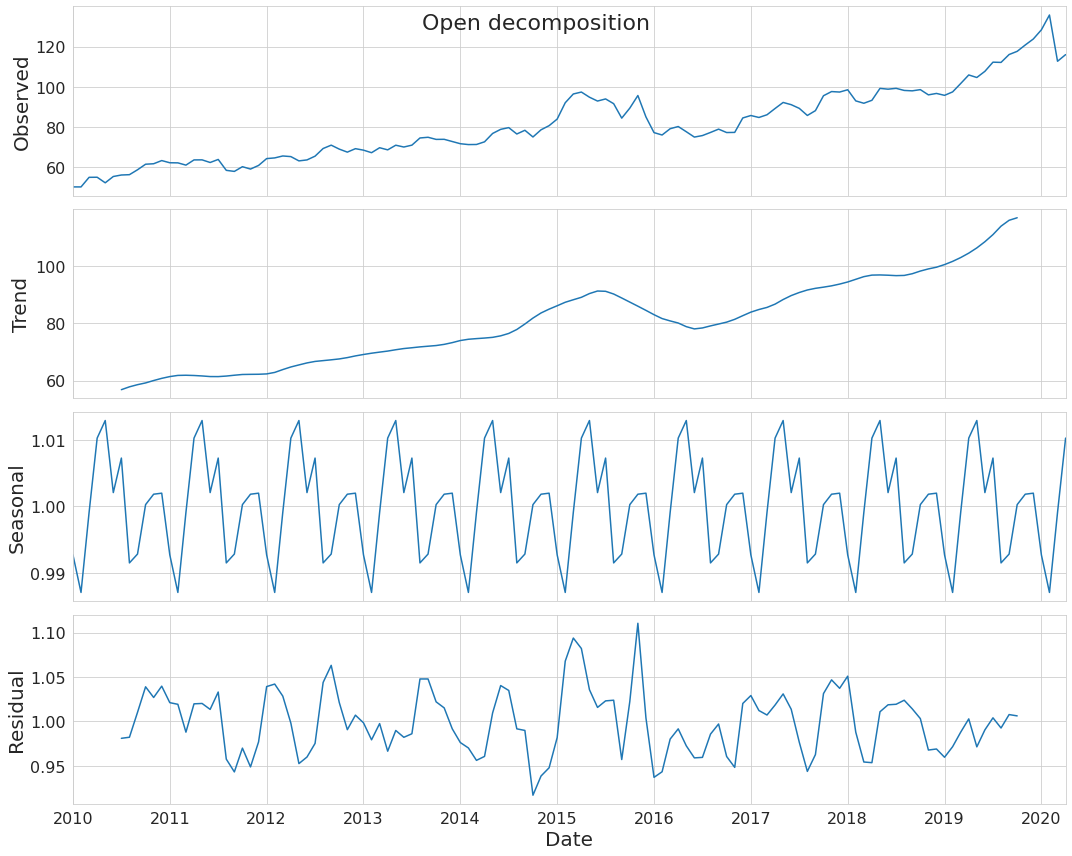

In [25]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Setting rcparams
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16

# Using statistical tools of statsmodel library
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', freq = 12)
decomp = decomposition.plot()
decomp.suptitle('Open decomposition', fontsize=22)

Stationarity

In [26]:
# check for stationarity
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['Open'],title='') 

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.196686
p-value                   0.938915
# lags used               2.000000
# observations          121.000000
critical value (1%)      -3.485585
critical value (5%)      -2.885739
critical value (10%)     -2.579676
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


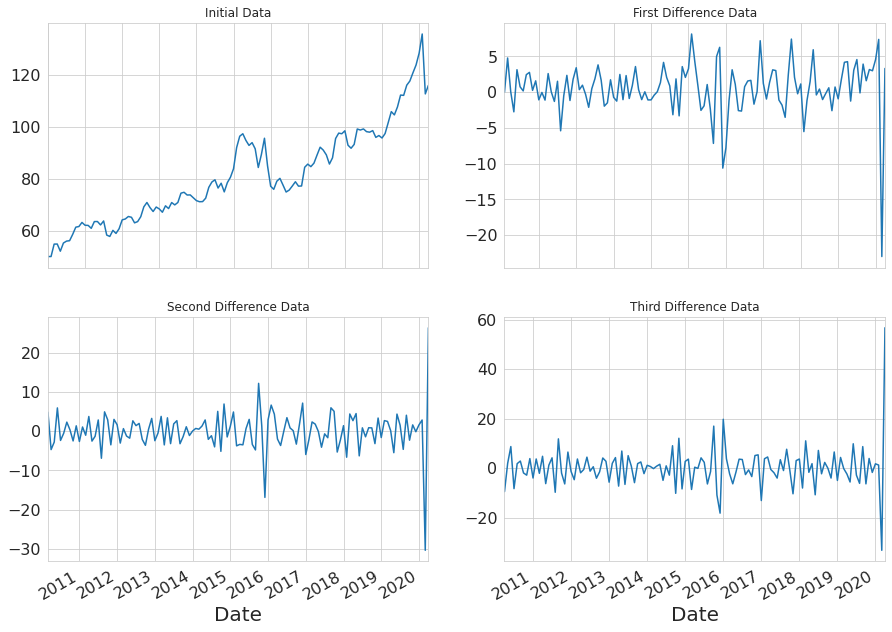

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15, 11))

y['OpenDiff1'] = diff(y['Open'],k_diff=1)
y['OpenDiff2'] = diff(y['Open'],k_diff=2)
y['OpenDiff3'] = diff(y['Open'],k_diff=3)

y['Open'].plot(title="Initial Data",ax=ax[0][0]).autoscale(axis='x',tight=True);
y['OpenDiff1'].plot(title="First Difference Data",ax=ax[0][1]).autoscale(axis='x',tight=True);
y['OpenDiff2'].plot(title="Second Difference Data",ax=ax[1][0]).autoscale(axis='x',tight=True);
y['OpenDiff3'].plot(title="Third Difference Data",ax=ax[1][1]).autoscale(axis='x',tight=True);

fig.autofmt_xdate()


Autocorrelation

Autocorrelation measures the linear relationship between lagged values of a time series, for example between  𝑦𝑡  and  𝑦𝑡−1. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag k is the autocorrelation between  𝑦𝑡 and  𝑦𝑡+𝑦𝑡+𝑘 that is not accounted for by lags 1 through k−1.

We essentially plot out the relationship between the previous day’s/month’s residuals versus the real values of the current day. In general, we expect the partial autocorrelation to drop off quite quickly.

[1.         0.99669167 0.99397744 0.99114807 0.98842329 0.98574882
 0.98327505 0.98065432 0.97792933 0.97569862 0.97316217 0.97091567
 0.96872365 0.96677005 0.96448024 0.96224729 0.95968184 0.95699272
 0.95423987 0.95126885 0.94815404 0.94479836 0.94160485 0.93854499
 0.93560843 0.93284805 0.92976929 0.92688093 0.92378304 0.92046489
 0.91730545 0.91394706 0.91064856 0.90743726 0.90426107 0.90102265
 0.89772752 0.89464738 0.89163062 0.88862379 0.88584496 0.88294789
 0.88021878 0.87768629 0.87519469 0.87266679 0.87039248 0.86809038
 0.86572663 0.86328034 0.86084315 0.85844897 0.85612914 0.85390287
 0.85154451 0.84929882 0.84707093 0.84483261 0.84257198 0.84030894
 0.83812315]


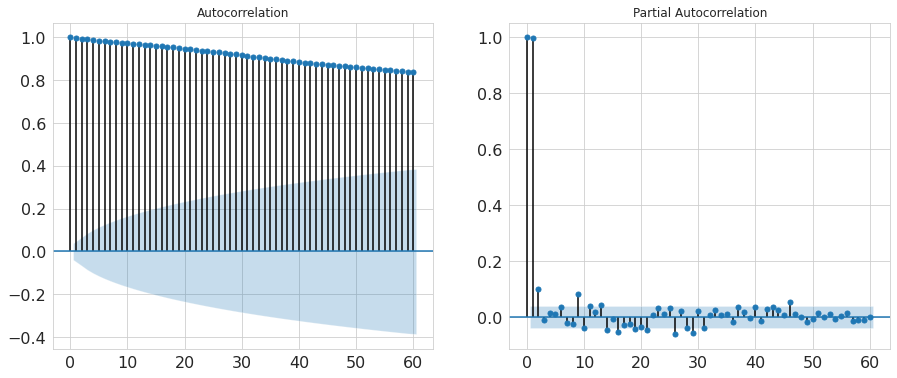

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))
autocorr = acf(imputed_air_liquide['Open'], nlags=60, fft=False)
print(autocorr)

plot_acf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[0], fft=False);
plot_pacf(imputed_air_liquide['Open'].tolist(), lags=60, ax=ax[1]);

For autocorrelation, the y-axis is the value for the correlation between a value and its lag. The lag is on the x-axis. The zero-lag has a correlation of 1 because it correlates with itself perfectly.

The autocorrelation plot shows that most of the spikes are not statistically significant. This indicates that the returns are not highly correlated, as shown here.

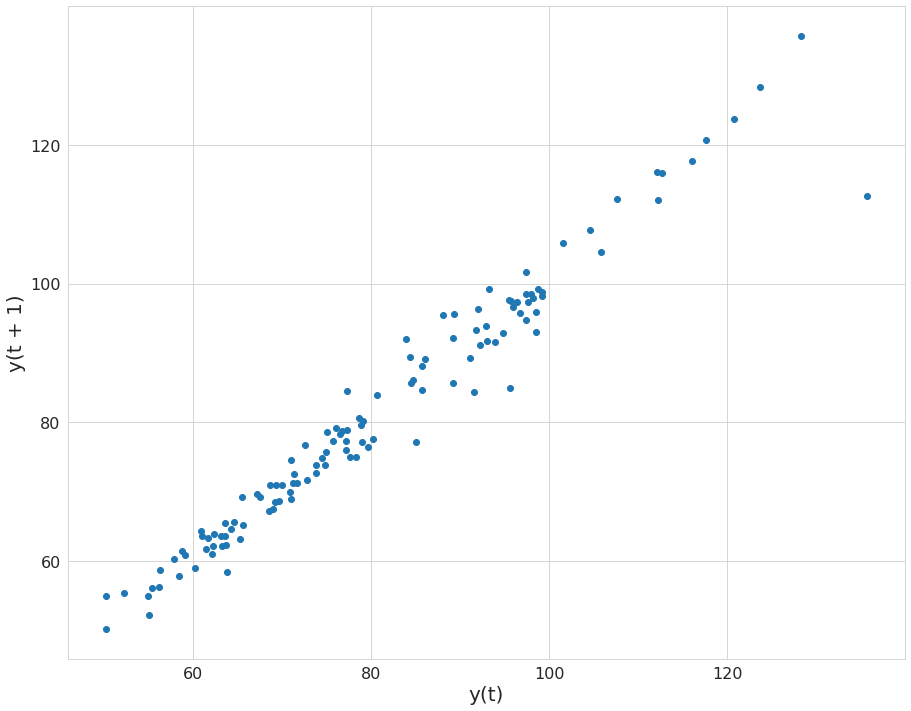

In [29]:
lag_plot(y['Open']);


Here we have a positive correlation relationship.

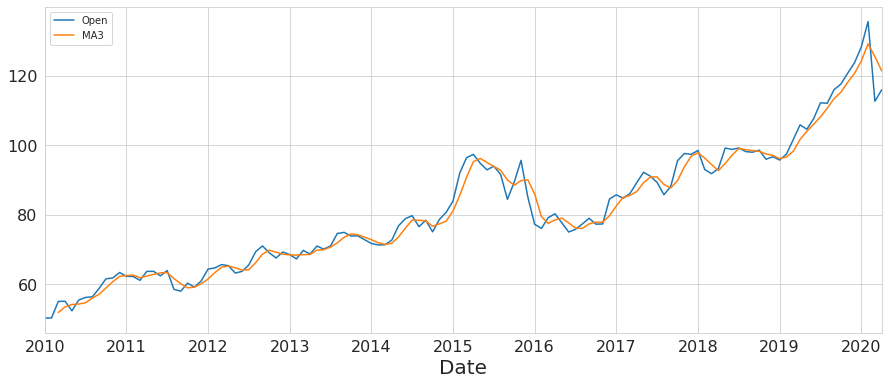

In [30]:
# Aggregating the Time Series to a monthly scaled index
y = imputed_air_liquide[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

y['MA3'] = y.rolling(window=3).mean() 
y.plot(figsize=(15,6));

Exponential smoothing

Exponential smoothing assigns exponentially decreasing weights for newest to oldest observations. In other words, the older the data, the less priority (“weight”) the data is given. Newer data is seen as more relevant and is assigned more weight. Smoothing parameters usually denoted by α ( 0 < α ≤ 1 ) determine the weights for observations. Exponential smoothing is usually used to make short term forecasts, as longer term forecasts using this technique can be quite unreliable.

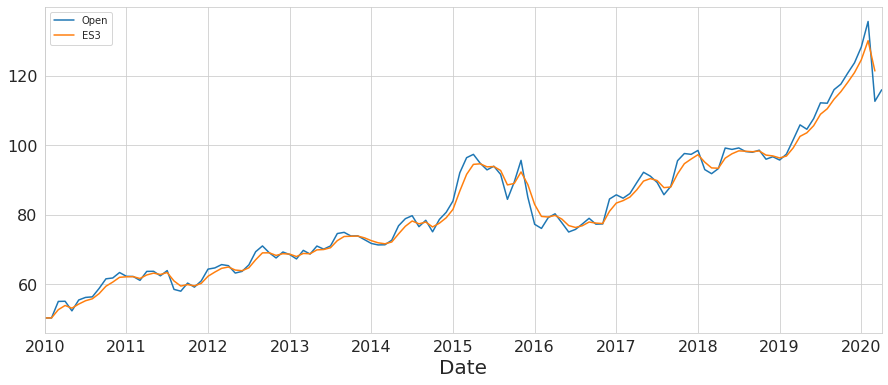

In [31]:
# Setting parameters value
span = 3
# Weights of observations
alpha = 2/(span+1)

# Plot Simple exponential smoothing
y['ES3'] = SimpleExpSmoothing(y['Open']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)
y[['Open','ES3']].plot(figsize=(15,6));

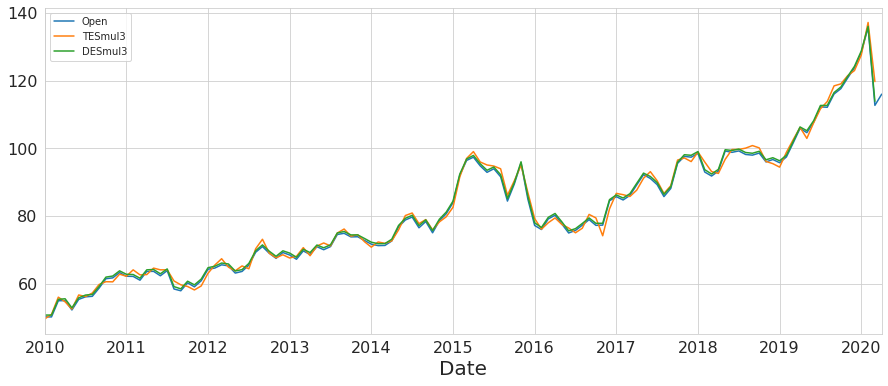

In [32]:
# Plot Double and Triple exponential smoothing
y['DESmul3'] = ExponentialSmoothing(y['Open'], trend = 'add').fit().fittedvalues.shift(-1)
y['TESmul3'] = ExponentialSmoothing(y['Open'], trend = 'add', seasonal = 'add', seasonal_periods = 12).fit().fittedvalues.shift(-1)
y[['Open', 'TESmul3', 'DESmul3']].plot(figsize = (15,6));

Forecasting with Auto ARIMA

In [33]:
# Reverse index so the dataframe is from oldest to newest values
imputed_air_liquide = imputed_air_liquide.reindex(index=imputed_air_liquide.index[::-1])

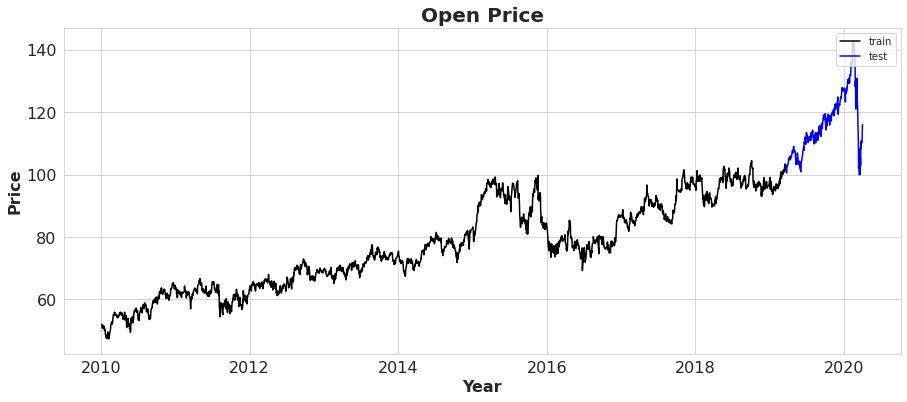

In [34]:
# Split data into train and validation set 90/10
air_liquide_train, air_liquide_val = imputed_air_liquide[:int(len(imputed_air_liquide)*0.9)], imputed_air_liquide[int(len(imputed_air_liquide)*0.9):]

# Index disappeared, put them back
air_liquide_val = air_liquide_val.set_index('Date', drop=False)
air_liquide_train = air_liquide_train.set_index('Date', drop=False)

# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(air_liquide_train['Date'], air_liquide_train['Open'], color = 'black')
sns.lineplot(air_liquide_val['Date'], air_liquide_val['Open'], color = 'blue')

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [35]:
%%time
model_autoARIMA = auto_arima(air_liquide_train['Open'])

""", 
                             start_p = 0, 
                             start_q = 0,
                             test = 'adf', # use adftest to find optimal 'd'
                             max_p = 3,
                             max_q = 3, # maximum p and q
                             m = 7, # frequency of series
                             seasonal = False,
                             start_P = 0, 
                             D = 0, 
                             trace = True,
                             error_action = 'ignore',  
                             stepwise = True
"""

print(model_autoARIMA.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 2340
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -3407.252
Date:                Thu, 21 Apr 2022   AIC                           6822.504
Time:                        02:36:51   BIC                           6845.534
Sample:                             0   HQIC                          6830.894
                               - 2340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9603      0.023     42.607      0.000       0.916       1.004
ma.L1         -1.0936      0.028    -38.388      0.000      -1.149      -1.038
ma.L2          0.1154      0.018      6.403      0.0

In [36]:
#ARIMA with defined p,d,q values

model = ARIMA(air_liquide_train['Open'], order = (1, 1, 2))
# disp=-1: no output
fitted = model.fit(disp = -1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Open   No. Observations:                 2339
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3403.083
Method:                       css-mle   S.D. of innovations              1.036
Date:                Thu, 21 Apr 2022   AIC                           6816.166
Time:                        02:37:45   BIC                           6844.954
Sample:                             1   HQIC                          6826.653
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0195      0.002     10.373      0.000       0.016       0.023
ar.L1.D.Open     0.9865      0.004    276.704      0.000       0.980       0.994
ma.L1.D.Open    -1.1254      0.021    -52.37

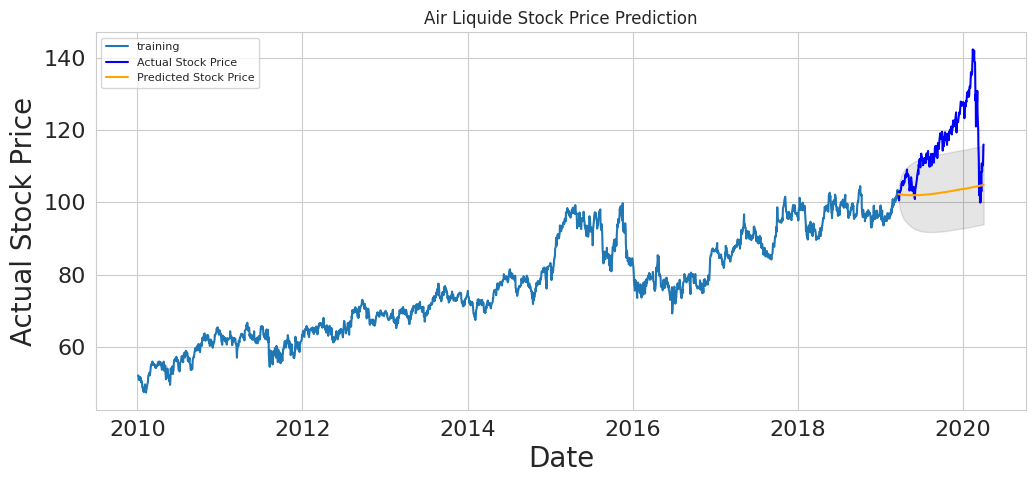

In [37]:
# Forecast 260 next observations 
fc, se, conf = fitted.forecast(260, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=air_liquide_val.index)
lower_series = pd.Series(conf[:, 0], index=air_liquide_val.index)
upper_series = pd.Series(conf[:, 1], index=air_liquide_val.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(air_liquide_train['Open'], label='training')
plt.plot(air_liquide_val['Open'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Air Liquide Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**Accuracy Metrics**

In [38]:
import math

# Report performance
mse = mean_squared_error(air_liquide_val['Open'], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(air_liquide_val['Open'], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(air_liquide_val['Open'], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - air_liquide_val['Open'])/np.abs(air_liquide_val['Open']))
print('MAPE: '+str(mape))

MSE: 252.9693187185026
MAE: 13.21420796283364
RMSE: 15.905009233524593
MAPE: 0.10858273657874212
